In [1]:
import os
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from src.data_modules import HSIDermoscopyDataModule
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyDataset


/mnt/datahdd/aline_conda/miniconda3/envs/hyperskin/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

config = {
    "task": "GENERATION",
    "train_val_test_split": (0.7, 0.15, 0.15),
    "image_size": 256,
    "batch_size": 4,
    "num_workers": 4,
    "pin_memory": True,
    "allowed_labels": None,
    "data_dir": "data/hsi_dermoscopy_cropped",
    "google_drive_id": "18fRaTH4FReHretz3OBJr3-takvxtDy1E",
    "balanced_sampling": False,
    "transforms": {
        "train": [
            {"class_path": "SmallestMaxSize", "init_args": {"max_size": 256}},
            {"class_path": "CenterCrop", "init_args": {"height": 256, "width": 256}},
            {"class_path": "Resize", "init_args": {"height": 256, "width": 256}},
        ],
        "val": [
            {"class_path": "SmallestMaxSize", "init_args": {"max_size": 256}},
            {"class_path": "CenterCrop", "init_args": {"height": 256, "width": 256}},
            {"class_path": "Resize", "init_args": {"height": 256, "width": 256}},
        ],
        "test": [
            {"class_path": "SmallestMaxSize", "init_args": {"max_size": 256}},
            {"class_path": "CenterCrop", "init_args": {"height": 256, "width": 256}},
            {"class_path": "Resize", "init_args": {"height": 256, "width": 256}},
        ],
    },
}

print("✅ Config loaded.")

✅ Config loaded.


In [3]:
data_module = HSIDermoscopyDataModule(**config)
print(data_module)
print("✅ Data module initialized.")

{Train dataloader: None}
{Validation dataloader: size=NA}
{Test dataloader: size=NA}
{Predict dataloader: None}
✅ Data module initialized.


In [4]:

print("Training transforms:", data_module.transforms_train)
print("Validation transforms:", data_module.transforms_val)
print("Test transforms:", data_module.transforms_test)


Training transforms: Compose([
  SmallestMaxSize(p=1.0, area_for_downscale=None, interpolation=1, mask_interpolation=0, max_size=256, max_size_hw=None),
  CenterCrop(p=1.0, border_mode=0, fill=0.0, fill_mask=0.0, height=256, pad_if_needed=False, pad_position='center', width=256),
  Resize(p=1.0, area_for_downscale=None, height=256, interpolation=1, mask_interpolation=0, width=256),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True, seed=None)
Validation transforms: Compose([
  SmallestMaxSize(p=1.0, area_for_downscale=None, interpolation=1, mask_interpolation=0, max_size=256, max_size_hw=None),
  CenterCrop(p=1.0, border_mode=0, fill=0.0, fill_mask=0.0, height=256, pad_if_needed=False, pad_position='center', width=256),
  Resize(p=1.0, area_for_downscale=None, height=256, interpolation=1, mask_interpolation=0, width=256),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True, seed=None)
Test transforms:

In [5]:

data_module.prepare_data()
print("✅ Data prepared.")
print("Dataset directory:", os.listdir(config["data_dir"])[:10])

✅ Data prepared.
Dataset directory: ['path_mapping.csv', 'images', 'metadata.csv']


In [6]:

data_dir = Path(config["data_dir"])
items = list(data_dir.iterdir())
print(f"📁 Dataset directory: {data_dir}")
for item in items:
    print(" -", item.name)

if (data_dir / "metadata.csv").exists():
    print("\n📄 Preview of metadata.csv:")
    metadata_df = pd.read_csv(data_dir / "metadata.csv")
    display(metadata_df.head())

if (data_dir / "path_mapping.csv").exists():
    print("\n📄 Preview of path_mapping.csv:")
    mapping_df = pd.read_csv(data_dir / "path_mapping.csv")
    display(mapping_df.head())

images_dir = data_dir / "images"
if images_dir.exists():
    print("\n🖼️ Example files inside 'images/' folder:")
    img_files = list(images_dir.glob("*"))[:10]
    for img in img_files:
        print(" -", img.name)

print(len(metadata_df), "total samples in metadata.csv")

📁 Dataset directory: data/hsi_dermoscopy_cropped
 - path_mapping.csv
 - images
 - metadata.csv

📄 Preview of metadata.csv:


,file_path,label,mask
0,data/hsi_dermoscopy_cropped/images/DNCube/106.mat,dysplastic_nevi,NaN
1,data/hsi_dermoscopy_cropped/images/DNCube/88.mat,dysplastic_nevi,NaN
2,data/hsi_dermoscopy_cropped/images/DNCube/116.mat,dysplastic_nevi,NaN
3,data/hsi_dermoscopy_cropped/images/DNCube/125.mat,dysplastic_nevi,NaN
4,data/hsi_dermoscopy_cropped/images/DNCube/158.mat,dysplastic_nevi,NaN



📄 Preview of path_mapping.csv:


,Unnamed: 0,original_path
0,export/hsi_dermoscopy_cropped/images/DNCube/12...,images/DNCube/124.mat
1,export/hsi_dermoscopy_cropped/images/DNCube/82...,images/DNCube/82.mat
2,export/hsi_dermoscopy_cropped/images/DNCube/40...,images/DNCube/40.mat
3,export/hsi_dermoscopy_cropped/images/DNCube/12...,images/DNCube/122.mat
4,export/hsi_dermoscopy_cropped/images/DNCube/17...,images/DNCube/173.mat



🖼️ Example files inside 'images/' folder:
 - DNCube
 - MMCube
 - OtherCube
312 total samples in metadata.csv


In [7]:
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyDataset, HSIDermoscopyTask

dataset = HSIDermoscopyDataset(
    task=HSIDermoscopyTask.GENERATION,  # same task you used in your config
    data_dir="data/hsi_dermoscopy_cropped"
)


unique_labels = dataset.labels_df["label"].unique()
print("🩺 Unique labels in dataset:", unique_labels)
print(f"Total samples in metadata.csv: {len(dataset.labels_df)}")

print("\n🔢 Label mapping (dataset.labels_map):")
for k, v in dataset.labels_map.items():
    print(f"  {k:25s} -> {v}")


dataset_indices = np.arange(len(dataset))
dataset_labels = dataset.labels_df["label"].map(dataset.labels_map).to_numpy()


🩺 Unique labels in dataset: ['dysplastic_nevi' 'melanoma' 'melanocytic_lesion' 'nevi' 'solar_lentigo'
 'interepidermal_carcinoma']
Total samples in metadata.csv: 312

🔢 Label mapping (dataset.labels_map):
  dysplastic_nevi           -> 0
  melanoma                  -> 1
  solar_lentigo             -> 2
  interepidermal_carcinoma  -> 3
  nevi                      -> 4
  seborrheic_keratosis      -> 5
  melanocytic_lesion        -> 6


In [8]:
split_dir = Path(config["data_dir"]).parent / "splits"
for name in ["train.txt", "val.txt", "test.txt"]:
    path = split_dir / name
    if path.exists():
        data = np.loadtxt(path, dtype=int)
        print(f"{name}: {len(data)} samples")



data_module.setup()
print(f"Train samples: {len(data_module.data_train)}")
print(f"Val samples: {len(data_module.data_val)}")
print(f"Test samples: {len(data_module.data_test)}")

Train samples: 217
Val samples: 46
Test samples: 47


In [9]:
dataset = data_module.data_train.dataset if hasattr(data_module.data_train, 'dataset') else data_module.data_train
print("Labels map:", dataset.labels_map)
print(dataset.labels_df.head())

Labels map: {'dysplastic_nevi': 0, 'melanoma': 1, 'solar_lentigo': 2, 'interepidermal_carcinoma': 3, 'nevi': 4, 'seborrheic_keratosis': 5, 'melanocytic_lesion': 6}
                                           file_path            label  mask
0  data/hsi_dermoscopy_cropped/images/DNCube/106.mat  dysplastic_nevi  None
1   data/hsi_dermoscopy_cropped/images/DNCube/88.mat  dysplastic_nevi  None
2  data/hsi_dermoscopy_cropped/images/DNCube/116.mat  dysplastic_nevi  None
3  data/hsi_dermoscopy_cropped/images/DNCube/125.mat  dysplastic_nevi  None
4  data/hsi_dermoscopy_cropped/images/DNCube/158.mat  dysplastic_nevi  None


Type of image: <class 'numpy.ndarray'>, shape: (256, 256, 16)
Type of label: <class 'torch.Tensor'>, value: 6


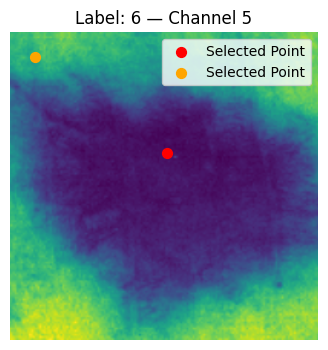

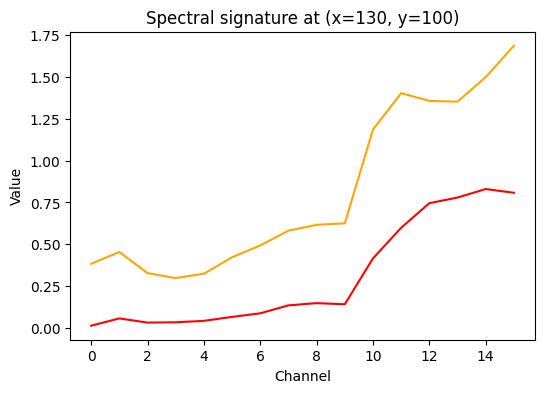

In [13]:
idx=np.random.randint(0, len(dataset))   # unpack tuple
image, label = dataset[idx]
print(f"Type of image: {type(image)}, shape: {image.shape}")
print(f"Type of label: {type(label)}, value: {label.item() if label.ndim == 0 else label}")

channel = 5  # choose any number between 0 and 15

# Choose x, y coordinates to highlight
x, y = 130, 100  # example coordinates, change as needed

plt.figure(figsize=(4, 4))
plt.imshow(image[..., channel])
plt.scatter([x], [y], color='red', s=50, marker='o', label='Selected Point')
plt.scatter([20], [20], color='orange', s=50, marker='o', label='Selected Point')
plt.title(f"Label: {label.item()} — Channel {channel}")
plt.axis("off")
plt.legend(loc='upper right')
plt.show()


spectral_values = image[y, x, :]  
plt.figure(figsize=(6, 4))
plt.plot(np.arange(image.shape[2]), spectral_values, color = 'red')
plt.plot(np.arange(image.shape[2]), image[20, 20, :], color='orange')
plt.title(f"Spectral signature at (x={x}, y={y})")
plt.xlabel("Channel")
plt.ylabel("Value")
plt.show()


In [14]:

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

batch = next(iter(train_loader))
if isinstance(batch, dict):
    print("Batch keys:", batch.keys())
    if 'image' in batch:
        print("Image batch shape:", batch['image'].shape)
else:
    print(type(batch))


Train batches: 55
Val batches: 12
Test batches: 12
<class 'list'>


In [15]:
from pprint import pprint

print("🧩 Training Transform Pipeline:")
for i, t in enumerate(data_module.transforms_train.transforms):
    print(f"{i+1}. {t.__class__.__name__}")
    pprint(vars(t))


🧩 Training Transform Pipeline:
1. SmallestMaxSize
{'_additional_targets': {},
 '_available_keys': {'bboxes',
                     'image',
                     'images',
                     'keypoints',
                     'mask',
                     'mask3d',
                     'masks',
                     'masks3d',
                     'volume',
                     'volumes'},
 '_key2func': {'bboxes': <bound method MaxSizeTransform.apply_to_bboxes of SmallestMaxSize(p=1.0, area_for_downscale=None, interpolation=1, mask_interpolation=0, max_size=256, max_size_hw=None)>,
               'image': <bound method MaxSizeTransform.apply of SmallestMaxSize(p=1.0, area_for_downscale=None, interpolation=1, mask_interpolation=0, max_size=256, max_size_hw=None)>,
               'images': <bound method MaxSizeTransform.apply_to_images of SmallestMaxSize(p=1.0, area_for_downscale=None, interpolation=1, mask_interpolation=0, max_size=256, max_size_hw=None)>,
               'keypoints': <boun

Raw image shape: (217, 427, 16)


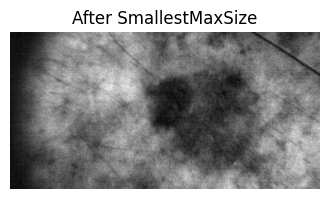

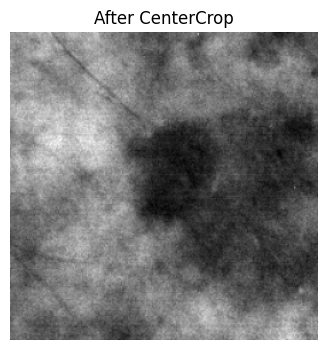

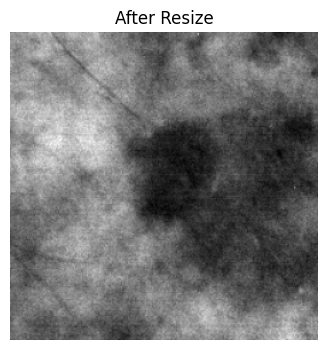

In [16]:
import albumentations as A

# Reload one raw sample from your dataset
raw_dataset = HSIDermoscopyDataset(
    task=data_module.hparams.task,
    data_dir=config["data_dir"]
)

raw_image, raw_label = raw_dataset[0]
print(f"Raw image shape: {raw_image.shape}")

# Albumentations expects numpy, ensure it’s float32
img_np = np.array(raw_image, dtype=np.float32)

# Get individual transforms from your pipeline
tforms = data_module.transforms_train.transforms

# Apply transforms incrementally
current = {"image": img_np}
for i, transform in enumerate(tforms, 1):
    transformed = transform(**current)
    img_transformed = transformed["image"]

    # Visualize
    plt.figure(figsize=(4, 4))
    plt.imshow(img_transformed[..., 0] if img_transformed.ndim == 3 else img_transformed, cmap="gray")
    plt.title(f"After {transform.__class__.__name__}")
    plt.axis("off")
    plt.show()

    current = transformed  # feed next transform


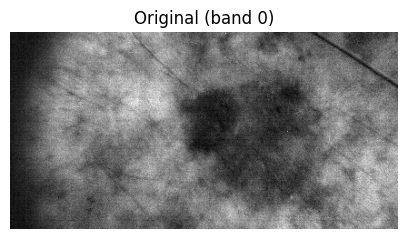

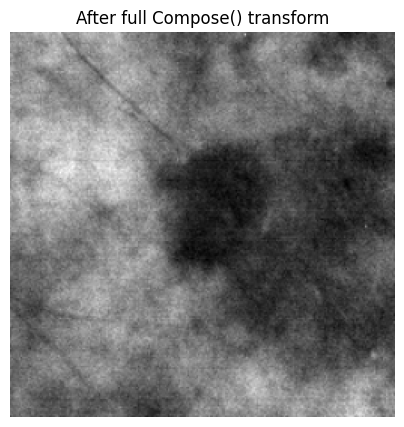

Original shape: (217, 427, 16), After transform: (256, 256, 16)


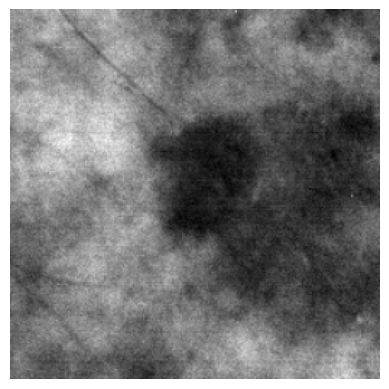

In [17]:
import matplotlib.animation as animation
# Full composed transform
compose_train = data_module.transforms_train

# Original raw image
plt.figure(figsize=(5, 5))
plt.imshow(img_np[..., 0], cmap="gray")
plt.title("Original (band 0)")
plt.axis("off")
plt.show()

# Transformed image
out = compose_train(image=img_np)
img_after = out["image"]

plt.figure(figsize=(5, 5))
plt.imshow(img_after[..., 0] if img_after.ndim == 3 else img_after, cmap="gray")
plt.title("After full Compose() transform")
plt.axis("off")
plt.show()

print(f"Original shape: {img_np.shape}, After transform: {img_after.shape}")

fig, ax = plt.subplots()
im = ax.imshow(img_after[..., 0], cmap='gray')
ax.axis('off')

def update(i):
    im.set_array(img_after[..., i])
    ax.set_title(f"Band {i}")
    return [im]

ani = animation.FuncAnimation(fig, update, frames=img_after.shape[2], interval=400)
plt.show()


In [ ]:

ani = animation.FuncAnimation(fig, update, frames=img_after.shape[2], interval=400)
plt.show()
ani.save("hyperspectral_animation.gif", writer="pillow", fps=2)
from IPython.display import Image
Image(filename="hyperspectral_animation.gif")
